### XG + LOF

In [60]:
from collections import Counter
from matplotlib import pyplot
from numpy import where

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 
import xgboost as xgb
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from numpy import loadtxt
from numpy import sort
from numpy import mean
from sklearn.metrics import cohen_kappa_score
#from autoimpute.imputations import MultipleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


from sklearn.impute import SimpleImputer 
from sklearn.metrics import plot_confusion_matrix
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC

from sklearn import svm
from sklearn.ensemble import VotingClassifier
from sklearn import model_selection
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

### Reading the data

In [2]:
df = pd.read_excel("Updated_UKBioBank.xlsx")

In [3]:
### removing the redundant column as advised by collaborators
df = df.iloc[:, df.columns != 'QTrest']

### Imputing values using SimpleImputer

In [4]:
imp = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
Imputed_df = imp.fit_transform(df)
# # 

In [5]:
df = pd.DataFrame(Imputed_df)
df = df.rename(columns={0: "eid", 1: "sex", 2:'RRrest', 3:'Tperest', 4:'QTc', 5:'QRS_rest', 6:'Age',
                       7:'BMI', 8:'Diab', 9:'smoke', 10:'DBP', 11:'SBP', 12:'chol', 13:'PR', 14:'AF', 15:'Arr'})

In [6]:
df.columns

Index(['eid', 'sex', 'RRrest', 'Tperest', 'QTc', 'QRS_rest', 'Age', 'BMI',
       'Diab', 'smoke', 'DBP', 'SBP', 'chol', 'PR', 'AF', 'Arr'],
      dtype='object')

In [7]:
df_no_overlap = df[~((df['AF']==1) & (df['Arr']==1))] # dataset where the patients that have both cases have been removed

In [8]:
healthy_patients = df_no_overlap[((df_no_overlap['AF']==0) & (df_no_overlap['Arr']==0))]

In [9]:
only_disease_df = df_no_overlap[((df_no_overlap['AF']==1) | (df_no_overlap['Arr']==1))] 

In [10]:
only_disease_df.shape

(1844, 16)

In [11]:
df_no_overlap.shape

(53895, 16)

In [12]:
### I am going to add the disease label now so I can remove outliers

In [13]:
only_disease_df.loc[(only_disease_df['Arr'] == 0) & (only_disease_df['AF'] == 1), 'Disease'] = 0
only_disease_df.loc[(only_disease_df['Arr'] == 1) & (only_disease_df['AF'] == 0), 'Disease'] = 1

C:\Users\user\anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\user\anaconda3\lib\site-packages\pandas\core\indexing.py:1601: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(new_indexer, value)
C:\Users\user\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

In [14]:
only_disease_df.head()

,eid,sex,RRrest,Tperest,QTc,QRS_rest,Age,BMI,Diab,smoke,DBP,SBP,chol,PR,AF,Arr,Disease
35,1003429.0,1.0,0.968,0.0645,0.355230,96.0,74.0,34.8141,0.0,0.0,85.5,141.5,0.0,166.0,1.0,0.0,0.0
44,1003947.0,1.0,0.858,0.0585,0.361661,76.0,67.0,28.8612,0.0,0.0,85.5,154.5,1.0,389.0,1.0,0.0,0.0
196,1017479.0,0.0,0.861,0.0690,0.452635,69.0,67.0,25.5567,0.0,0.0,64.5,116.0,0.0,131.0,1.0,0.0,0.0
199,1017854.0,1.0,0.807,0.0665,0.387941,50.0,43.0,32.2029,0.0,0.0,81.0,131.0,0.0,146.0,1.0,0.0,0.0
215,1019465.0,0.0,1.020,0.0525,0.382692,44.0,64.0,29.9301,0.0,0.0,84.0,152.5,1.0,138.0,1.0,0.0,0.0


In [15]:
for_outlier_x = only_disease_df.loc[:, ~only_disease_df.columns.isin(['eid','AF', 'Arr', 'Disease'])]
for_outlier_y = only_disease_df['Disease']

### Outlier Detection using Local Outlier Factor
using this over Isolation forest because Isolation forest is weak at detecting local outliers, while local outlier factor
is great at detecting both global and local outliers. 

In [16]:
from sklearn.neighbors import LocalOutlierFactor

In [17]:
clf = LocalOutlierFactor(n_neighbors=2)
for_outlier_y_pred = clf.fit_predict(for_outlier_x)

In [18]:
clf.negative_outlier_factor_

array([-1.48014605, -1.80997148, -1.12774956, ..., -1.01667992,
       -1.09340482, -1.07360642])

In [19]:
for_outlier_y_pred[for_outlier_y_pred == 1]

array([1, 1, 1, ..., 1, 1, 1])

In [20]:
for_outlier_x['outlier_score'] = for_outlier_y_pred
for_outlier_x['Disease'] = for_outlier_y
for_outlier_x['eid'] = only_disease_df['eid']
for_outlier_x['Arr'] = only_disease_df['Arr']
for_outlier_x['AF'] = only_disease_df['AF']

<ipython-input-20-391940843797>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_outlier_x['outlier_score'] = for_outlier_y_pred
<ipython-input-20-391940843797>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_outlier_x['Disease'] = for_outlier_y
<ipython-input-20-391940843797>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

In [21]:
for_outlier_x['outlier_score'].value_counts()

 1    1783
-1      61
Name: outlier_score, dtype: int64

In [22]:
for_outlier_x['Disease'].value_counts()

0.0    1682
1.0     162
Name: Disease, dtype: int64

In [23]:
without_outliers = for_outlier_x[for_outlier_x['outlier_score'] == 1]

In [24]:
without_outliers.shape

(1783, 18)

In [25]:
without_outliers['Disease'].value_counts()

0.0    1625
1.0     158
Name: Disease, dtype: int64

In [26]:
without_outliers = without_outliers.loc[:,without_outliers.columns != 'outlier_score']

In [27]:
without_outliers.head()

,sex,RRrest,Tperest,QTc,QRS_rest,Age,BMI,Diab,smoke,DBP,SBP,chol,PR,Disease,eid,Arr,AF
35,1.0,0.968,0.0645,0.355230,96.0,74.0,34.8141,0.0,0.0,85.5,141.5,0.0,166.0,0.0,1003429.0,0.0,1.0
196,0.0,0.861,0.0690,0.452635,69.0,67.0,25.5567,0.0,0.0,64.5,116.0,0.0,131.0,0.0,1017479.0,0.0,1.0
199,1.0,0.807,0.0665,0.387941,50.0,43.0,32.2029,0.0,0.0,81.0,131.0,0.0,146.0,0.0,1017854.0,0.0,1.0
215,0.0,1.020,0.0525,0.382692,44.0,64.0,29.9301,0.0,0.0,84.0,152.5,1.0,138.0,0.0,1019465.0,0.0,1.0
256,0.0,0.906,0.0715,0.419188,76.0,58.0,26.7149,0.0,1.0,98.0,151.5,0.0,162.0,0.0,1022683.0,0.0,1.0


In [28]:
### setting aside test sample so the classifier doesn't perform data leakage

In [29]:
choosing_samples_AF = without_outliers[without_outliers['AF'] == 1]
choosing_samples_Arr =  without_outliers[without_outliers['Arr'] == 1]

test_AF_samples = choosing_samples_AF.sample(10, replace=False, random_state = 123)
test_Arr_samples = choosing_samples_Arr.sample(10, replace=False, random_state = 123)

In [30]:
test_sample = pd.concat([test_AF_samples, test_Arr_samples])

In [31]:
#test_sample = without_outliers.sample(100, replace=False, random_state = 123)
j1 = test_sample.set_index('eid').index
j2 = without_outliers.set_index('eid').index
j3 = without_outliers.set_index('eid').index
sample_to_use = without_outliers[~j2.isin(j1)]
sample_to_use_withlabels =  without_outliers[~j3.isin(j1)]

In [32]:
sample_to_use.shape

(1763, 17)

In [33]:
test_sample['Disease'].value_counts()

1.0    10
0.0    10
Name: Disease, dtype: int64

In [34]:
test_sample.columns

Index(['sex', 'RRrest', 'Tperest', 'QTc', 'QRS_rest', 'Age', 'BMI', 'Diab',
       'smoke', 'DBP', 'SBP', 'chol', 'PR', 'Disease', 'eid', 'Arr', 'AF'],
      dtype='object')

In [35]:
test_sample.shape

(20, 17)

In [36]:
sample_to_use.shape

(1763, 17)

In [37]:
## adding smote to the picture

In [38]:
AF_data = sample_to_use.drop(columns=['Arr'], axis=1) # data with only the AF label
Arr_data = sample_to_use.drop(columns=['AF'], axis=1) # data with only the Arr label

In [39]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [40]:
arr_x = Arr_data.loc[:,Arr_data.columns != 'Arr']
arr_y = Arr_data['Arr']

oversample_arr = RandomOverSampler(random_state=42, sampling_strategy=0.8)
arr_x, arr_y = oversample_arr.fit_resample(arr_x, arr_y)

In [41]:
Counter(arr_y)

Counter({0.0: 1615, 1.0: 1292})

In [43]:
af_x = AF_data.loc[:,AF_data.columns != 'AF']
af_y = AF_data['AF']
Counter(af_y)

Counter({1.0: 1615, 0.0: 148})

In [44]:
arr_x['Arr'] = arr_y
af_x['AF'] = af_y

In [45]:
AF_only = af_x[af_x['AF'] == 1] # data with only positive labels of AF
Arr_only = arr_x[arr_x['Arr'] ==1] # data with only positive labels of Arr

In [46]:
with_oversample_df = pd.concat([AF_only, Arr_only])

In [47]:
with_oversample_df.head()

,sex,RRrest,Tperest,QTc,QRS_rest,Age,BMI,Diab,smoke,DBP,SBP,chol,PR,Disease,eid,AF,Arr
35,1.0,0.968,0.0645,0.355230,96.0,74.0,34.8141,0.0,0.0,85.5,141.5,0.0,166.0,0.0,1003429.0,1.0,NaN
196,0.0,0.861,0.0690,0.452635,69.0,67.0,25.5567,0.0,0.0,64.5,116.0,0.0,131.0,0.0,1017479.0,1.0,NaN
199,1.0,0.807,0.0665,0.387941,50.0,43.0,32.2029,0.0,0.0,81.0,131.0,0.0,146.0,0.0,1017854.0,1.0,NaN
215,0.0,1.020,0.0525,0.382692,44.0,64.0,29.9301,0.0,0.0,84.0,152.5,1.0,138.0,0.0,1019465.0,1.0,NaN
256,0.0,0.906,0.0715,0.419188,76.0,58.0,26.7149,0.0,1.0,98.0,151.5,0.0,162.0,0.0,1022683.0,1.0,NaN


In [48]:
with_oversample_df.head()

,sex,RRrest,Tperest,QTc,QRS_rest,Age,BMI,Diab,smoke,DBP,SBP,chol,PR,Disease,eid,AF,Arr
35,1.0,0.968,0.0645,0.355230,96.0,74.0,34.8141,0.0,0.0,85.5,141.5,0.0,166.0,0.0,1003429.0,1.0,NaN
196,0.0,0.861,0.0690,0.452635,69.0,67.0,25.5567,0.0,0.0,64.5,116.0,0.0,131.0,0.0,1017479.0,1.0,NaN
199,1.0,0.807,0.0665,0.387941,50.0,43.0,32.2029,0.0,0.0,81.0,131.0,0.0,146.0,0.0,1017854.0,1.0,NaN
215,0.0,1.020,0.0525,0.382692,44.0,64.0,29.9301,0.0,0.0,84.0,152.5,1.0,138.0,0.0,1019465.0,1.0,NaN
256,0.0,0.906,0.0715,0.419188,76.0,58.0,26.7149,0.0,1.0,98.0,151.5,0.0,162.0,0.0,1022683.0,1.0,NaN


In [49]:
with_oversample_df.loc[(with_oversample_df['Arr'].isnull()) & (with_oversample_df['AF'] == 1), 'Arr'] = 0
with_oversample_df.loc[(with_oversample_df['AF'].isnull()) & (with_oversample_df['Arr'] == 1), 'AF'] = 0

In [50]:
with_oversample_df['AF'].value_counts()

1.0    1615
0.0    1292
Name: AF, dtype: int64

In [51]:
oversampled_x = with_oversample_df.loc[:,with_oversample_df.columns != 'Disease']
oversampled_y = with_oversample_df['Disease']

In [52]:
with_oversample_df = oversampled_x.copy()
with_oversample_df['Disease'] = oversampled_y

In [53]:
test_sample.loc[(test_sample['Arr'] == 0) | (test_sample['AF'] == 1), 'Disease'] = 0
test_sample.loc[(test_sample['Arr'] == 1) & (test_sample['AF'] == 0), 'Disease'] = 1

In [54]:
test_sample = test_sample[((test_sample['AF']==1) | (test_sample['Arr']==1))]

In [55]:
test_sample.head()


,sex,RRrest,Tperest,QTc,QRS_rest,Age,BMI,Diab,smoke,DBP,SBP,chol,PR,Disease,eid,Arr,AF
37522,0.0,0.990,0.0570,0.419603,49.0,57.0,33.3095,0.0,0.0,92.0,143.5,0.0,97.0,0.0,4482089.0,0.0,1.0
44711,0.0,1.034,0.0655,0.370258,60.0,59.0,38.2299,0.0,0.0,90.0,144.5,0.0,133.0,0.0,5152992.0,0.0,1.0
30354,1.0,0.726,0.0565,0.378496,82.0,63.0,25.3287,0.0,1.0,98.5,157.5,0.0,152.0,0.0,3816384.0,0.0,1.0
22467,0.0,0.780,0.0610,0.377048,68.0,63.0,24.7014,0.0,0.0,81.0,143.5,0.0,126.0,0.0,3086709.0,0.0,1.0
28197,1.0,0.984,0.0665,0.374508,69.0,67.0,28.8933,0.0,0.0,80.0,142.0,0.0,138.0,0.0,3619736.0,0.0,1.0


In [56]:
with_oversample_df['Disease'].value_counts()

0.0    1615
1.0    1292
Name: Disease, dtype: int64

In [57]:
with_oversample_df = with_oversample_df.drop(columns=['AF', 'Arr'])
X = with_oversample_df.loc[:, ~with_oversample_df.columns.isin(['Disease', 'eid'])]
y = with_oversample_df['Disease']

In [58]:
test_sample = test_sample.drop(columns=['AF', 'Arr'])
X_test = test_sample.loc[:, ~test_sample.columns.isin(['Disease','eid'])]
y_test = test_sample['Disease']

In [59]:
X_test.head()

,sex,RRrest,Tperest,QTc,QRS_rest,Age,BMI,Diab,smoke,DBP,SBP,chol,PR
37522,0.0,0.990,0.0570,0.419603,49.0,57.0,33.3095,0.0,0.0,92.0,143.5,0.0,97.0
44711,0.0,1.034,0.0655,0.370258,60.0,59.0,38.2299,0.0,0.0,90.0,144.5,0.0,133.0
30354,1.0,0.726,0.0565,0.378496,82.0,63.0,25.3287,0.0,1.0,98.5,157.5,0.0,152.0
22467,0.0,0.780,0.0610,0.377048,68.0,63.0,24.7014,0.0,0.0,81.0,143.5,0.0,126.0
28197,1.0,0.984,0.0665,0.374508,69.0,67.0,28.8933,0.0,0.0,80.0,142.0,0.0,138.0


In [140]:
estimators = []

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)
model1 = xgb.XGBClassifier(objective='binary:logistic', subsample=0.75,  
                          n_estimators=100, colsample_bytree = 0.99, learning_rate = 1,
                max_depth = 10,  gamma=5, alpha = 1, seed=123, use_label_encoder=False, eval_metric='error')
estimators.append(('XGBoost', model1))
estimators.append(('bayes', GaussianNB()))
estimators.append(('GradientDescent' , SGDClassifier(loss="modified_huber", penalty="elasticnet", max_iter=500)))
ensemble = VotingClassifier(estimators, voting = 'soft')

In [141]:
ensemble.fit(X, y)
y_pred = ensemble.predict(X_test)

In [142]:
y_test.value_counts()

1.0    10
0.0    10
Name: Disease, dtype: int64

In [143]:
Counter(y_pred)

Counter({0.0: 9, 1.0: 11})

In [144]:
from sklearn.metrics import f1_score
f1_score = f1_score(y_test, y_pred)
print('f1_score: %.3f' % f1_score)
from sklearn.metrics import precision_score
precision = precision_score(y_test, y_pred)
print('Precision: %.3f' % precision)

from sklearn.metrics import recall_score
recall = recall_score(y_test, y_pred, average='binary')
print('Recall: %.3f' % recall)

f1_score: 0.571
Precision: 0.545
Recall: 0.600


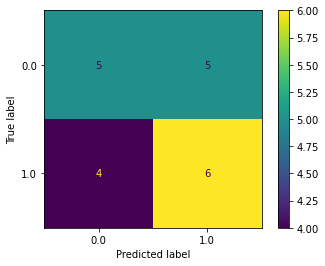

In [145]:
plot_confusion_matrix(ensemble, X_test, y_test) 

In [146]:
from sklearn.metrics import precision_recall_fscore_support,classification_report,confusion_matrix, precision_recall_curve
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.56      0.50      0.53        10
         1.0       0.55      0.60      0.57        10

    accuracy                           0.55        20
   macro avg       0.55      0.55      0.55        20
weighted avg       0.55      0.55      0.55        20

